# AUDiaL: Evaluation Report

This notebook outlines the evaluation methodology of [AUDiaL](https://github.com/tomurillo/AUDiaL) (<strong>A</strong>ccessible <strong>U</strong>niversal <strong>Dia</strong>grams through <strong>L</strong>anguage), a Web prototype of a Natural Language Interface (NLI) to diagrams in order to make statistical charts accessible to the visually impaired population.

Let us first load the required Python dependencies:

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 6]

## Evaluation Questions

AUDiaL is a Web-based prototype of a NLI to statistical diagrams, such as bar charts. It was designed and implemented in order to test a number of research questions:
<ol>
    <li>Is natural language a sufficient means for non-visual autonomous access to diagrams for blind persons?</li>
    <li>Can visualization semantics encoded via ontologies be efficiently retrieved via a Natural Language Interface (NLI)?</li>
    <li>How should a NLI be adapted for the specific needs of blind persons reading diagrams?</li>
</ol>

In order to answer these questions, AUDiaL was employed in a number of evaluation sessions with blind participants. In each session, participants were asked to solve tasks of increasing difficulty using both AUDiaL and their preferred means of accessing diagrams. Qualitative and quantitative measures of the efficacy of AUDiaL in comparison with traditional alternative diagram versions were gathered from analyzing several measures of how participants solved these tasks. 

## Method

In [2]:
CSV_DIR = 'data'
DEMO_FILE = 'AUDiaL_evaluation_anonymized.csv'
demo_data = np.genfromtxt(os.path.join(CSV_DIR, DEMO_FILE), dtype=None, delimiter=',', names=True, encoding=None)
N = demo_data.shape[0]
print('N={} participants.'.format(N))

N=8 participants.


## Efficiency

Efficiency was measured by observing how long it took participants to complete the tasks. Time was kept via analyzing the system logs for AUDiaL, and by manually measuring it for the table-based tasks. Manual timekeeping is not as accurate as system log timestamps are, thus they are rounded to the nearest minute.

Because both the answers for *Task 1* and *Task 2* could be fetched from the diagram's summary, most participants required a very short time to complete *Task 2*. For this reasons, the times of *Task 1* and *Task 2* have been combined into a single timestamp in the analysis.

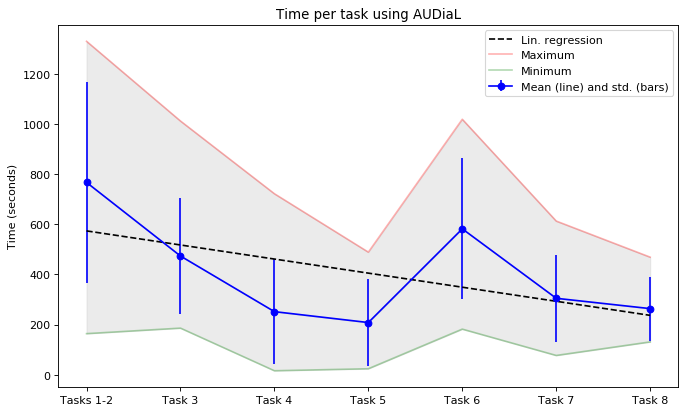

In [66]:
means = []
stds = []
maxs = []
mins = []
x_combine = []
t_combine = []

# Collect data and compute mean, std, min, and max for each task
i = 2
while True:
    try:
        times = demo_data[:]['Dialogue__Time__{}'.format(i)]
        if i == 2:
            times = np.add(times, demo_data[:]['Dialogue__Time__1'])  # Combine Task 1 and Task 2
        times = times[np.where(times > 0)[0]]  # Missing values are set to -1; skip them
        x_combine.extend([i-2 for _ in range(len(times))])
        t_combine.extend(times)
        means.append(times.mean())
        stds.append(times.std())
        maxs.append(times.max())
        mins.append(times.min())
        i += 1
    except ValueError:
        break

# Horizontal axis values (zero-indexed)
x = np.arange(i-2)

# Linear regression of datapoints
linfit = np.polyfit(x_combine, t_combine, 1)
linfit_fn = np.poly1d(linfit)

# Plot all
xticks = ['Tasks 1-2']
xticks.extend(['Task {}'.format(j) for j in range(3, i)])
fig = plt.figure(figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.errorbar(x, means, stds, linestyle='-', marker='o', color='b', label='Mean (line) and std. (bars)')
plt.plot(x, linfit_fn(x), '--k', label='Lin. regression')
plt.plot(x, maxs, color='r', alpha=.3, label='Maximum')
plt.fill_between(x, means, maxs, color='silver', alpha=.3)
plt.fill_between(x, means, mins, color='silver', alpha=.3)
plt.plot(x, mins, color='g', alpha=.3, label='Minimum')
plt.xticks(x, xticks)
plt.ylabel('Time (seconds)')
plt.title('Time per task using AUDiaL')
plt.legend(loc='upper right')
plt.show()

From the plot above, the following conclusions can be derived:
<ul>
    <li>As shown by the linear regression fitting line, time per task decreases with time as participants got used to the Web prototype. This fact is exacerbated if we consider that latter tasks are harder to asnwer than the previous ones.</li>
    <li>Tasks 1 and 2 took users the longest to solve, as participants spent a long time reading the summary and exploring the diagrams.</li>
</ul>